In [74]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot  as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

In [75]:
#Importing City and Resort hotel files
df = pd.read_csv("H1.csv")
df1 = pd.read_csv("H2.csv")
#Labeling to distinguish the respective hotel 
df["hotel"] = np.full(len(df.Agent),"H1")
df1["hotel"] = np.full(len(df1.Agent),"H2")
# concatination of Data Frame
data = pd.concat([df,df1] , axis=0)
# Reservation Status is closely related to the classification label and the date is ralated to booking date.
# Including both columns will improve the precision of our model but we need to make a prediction without
#the knowledge of the reservation status information 
data.drop(['ReservationStatus', 'ReservationStatusDate'], axis="columns", inplace=True)
# spliting the features by data types
mask_fea_int = data.dtypes == 'object'
cat_fea_int = data.columns[mask_fea_int].tolist()
# Removing the leading and lagging spaces
for col in cat_fea_int:
    data[col] = data[col].str.strip()
data.hotel.replace(["H1", "H2"], ["City Hotel", "Resort Hotel"], inplace=True)
data.shape

(119390, 30)

In [76]:
# Converting object data type to numeric and setting NaN to any error
data['Agent'] = pd.to_numeric(data.Agent,errors='coerce')
data['Company'] = pd.to_numeric(data.Company, errors='coerce')
data.Meal.replace ("Undefined", "SC", inplace=True)
# Splitting numeric and categorical features again to include the current transformation
mask_fea = data.dtypes == 'object'
cat_fea = data.columns[mask_fea].tolist()
num_fea = data.columns[mask_fea==False ].tolist()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 79329
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13  

In [77]:
# The share of booking number per hotel 
hotel = data[data.IsCanceled == 0].groupby("hotel").size().reset_index(name="count")

In [78]:
fig = px.pie(hotel, names = "hotel", values = "count", title = "Number of guests per hotel")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [79]:
# We can observe that Resort Hotel leads in terms of booking
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,hotel
0,0,342,2015,July,27,1,0,0,2,0.0,...,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,City Hotel
1,0,737,2015,July,27,1,0,0,2,0.0,...,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,City Hotel
2,0,7,2015,July,27,1,0,1,1,0.0,...,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,City Hotel
3,0,13,2015,July,27,1,0,1,1,0.0,...,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,City Hotel
4,0,14,2015,July,27,1,0,2,2,0.0,...,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,City Hotel


In [80]:
meal_c =data[data.IsCanceled == 0].groupby("Meal").size().reset_index(name="count")

In [81]:
fig= px.pie(meal_c, names="Meal", values="count", title = "Meal type based distribution")
fig.update_traces(textposition='inside', textinfo= 'percent+label')
fig.show()

In [82]:
# Correlation of numeric features with target and visualization with heatmap
corr = round(data[num_fea].corr().abs(), 2)
corr.sort_values("IsCanceled",ascending = False, inplace =True, axis=0)
print(cat_fea)

['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType', 'hotel']


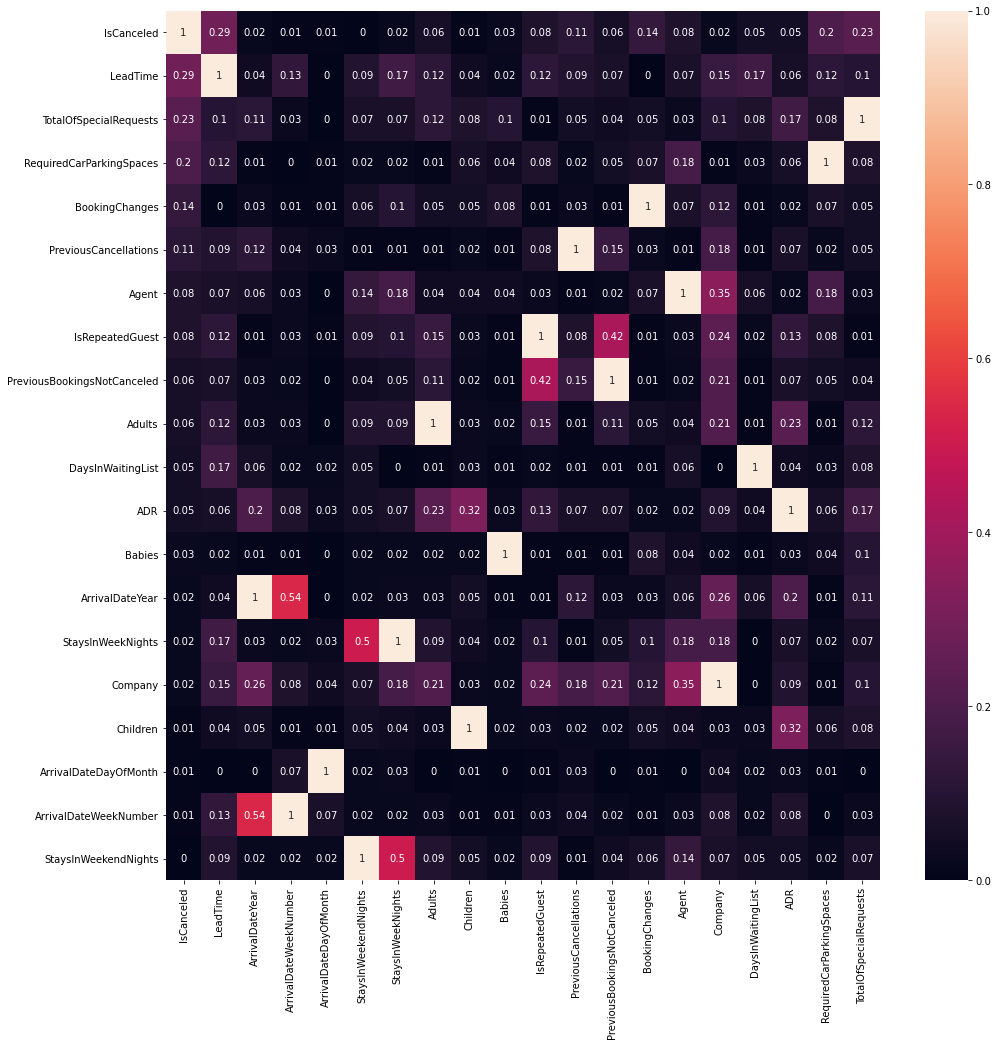

In [83]:
sns.heatmap(corr,annot=True)
fig = plt.gcf()
fig.set_size_inches(16,16)

In [84]:
# Extracting the 6 best correlated features
num_corr =  corr.nlargest(6,"IsCanceled").index.tolist()

In [85]:
num_corr.remove("IsCanceled")

In [86]:
print(num_corr)

['LeadTime', 'TotalOfSpecialRequests', 'RequiredCarParkingSpaces', 'BookingChanges', 'PreviousCancellations']


In [87]:
# Training Logistic Regression model with 6 best correlated numeric features 
logreg = LogisticRegression(solver="liblinear")
X = data[num_corr]
y= data["IsCanceled"]

confusion Matrix


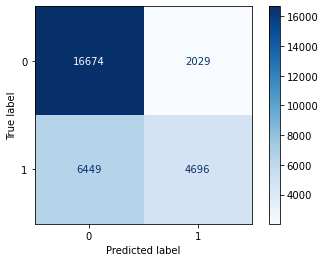

In [88]:
#cross_val_score(logreg, X, y, cv =5 , scoring = "accuracy").mean()
X_train, X_test, Y_train, Y_test = train_test_split(X,y, random_state = None)
RgModel = logreg.fit(X_train, Y_train)
plot_confusion_matrix(RgModel, X_test, Y_test, cmap=plt.cm.Blues, normalize = None)
print('confusion Matrix')
plt.show()

In [105]:
# Including the categorical features, transforming and cross validating with Decision Tree classifier
feature = num_corr + cat_fea
X1 = data[feature]
num_transf = SimpleImputer(strategy = "constant")
cat_transf = Pipeline(steps=[
    ("inputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown = 'ignore'))])
pre_process =  ColumnTransformer(transformers=[("num", num_transf, num_corr),
                                               ("cat", cat_transf, cat_fea)])
Classmodel = [('Decision Tree', DecisionTreeClassifier(random_state=42)),
              ('Regression Logistic', LogisticRegression(solver="liblinear")),
              ('Random Forest', RandomForestClassifier(max_depth=2, random_state=0))]
kfolds = 5
result = []
split = KFold(n_splits = kfolds, shuffle=True, random_state=42)
for modelName, model in Classmodel:
                model_pro = Pipeline(steps= [('preprossor', pre_process), (modelName, model)])
                result.append((modelName, cross_val_score(model_pro, X1,y, cv=split, scoring="accuracy", n_jobs=-1).mean()))
               
#the best model out of the three based on average accuracy
bestModel = max (result, key = lambda x : x[1])
print('The best model is %s and the accuracy is %s' % (bestModel[0],"{:.2%}".format(bestModel[1])))               
               
  

The best model is Decision Tree and the accuracy is 84.28%


In [90]:
# Only half of the intial features used and the cross validation score is 84 %
print(len(feature))

15
